# Creating the Dataset

In [15]:
import torch
import numpy as np
import  pandas as pd

class DataSet:
    """
    This class is used to create the data to be used in the LSTM model
    """
    def __init__(self, fp='C:\Education\MSCS UDC\Research Projects\CCT Project\datasets\Ammonium ACTSOR-AQUA-UDC-1 2017-01-26T01%3A01&to=2017-01-26T12%3A59.json', look_back=5) -> None:
        self.fp = fp # file path
        self.data = self.load_file() 
        self.look_back = look_back
        self.dataset = self.__data() 
        self.X, self.y = self.create_dataset()

    def load_file(self):
        data = pd.read_json(self.fp)
        data['readTime'] = pd.to_datetime(data['readTime'])
        data.set_index('readTime', inplace=True)
        return data


    def __data(self):
        """
        Perfom min-max scaling on the data
        """
        dataset = self.data
        max_value = np.max(dataset['ammonium']) 
        min_value = np.min(dataset['ammonium']) 
        range_val = max_value - min_value
        return list(map(lambda x: x/range_val, dataset['ammonium']))

    def create_dataset(self):
        X, y = [], []
        for i in range(len(self.dataset) - self.look_back): # create sequences with labels.
            a = self.dataset[i:(i+self.look_back)]
            X.append(a)
            y.append(self.dataset[i+self.look_back])
        return np.array(X), np.array(y)

    def perfom_splits(self):
        """
        Create a training and testing split on the data
        """
        train_size = int(len(self.X)*0.9)
        test_size = len(self.X) - train_size
        x_train, y_train = self.X[:train_size], self.y[:train_size]
        x_test, y_test = self.X[train_size:], self.y[train_size:]
        x_train,x_test = torch.from_numpy(x_train.reshape(-1, 1, self.look_back)), \
            torch.from_numpy(x_test.reshape(-1, 1, self.look_back))
        y_train, y_test = torch.from_numpy(y_train.reshape(-1, 1, 1)), \
            torch.from_numpy(y_test.reshape(-1, 1, 1))

        assert y_train.size()[0] == x_train.size()[0]
        assert y_train.size()[1:] == y_test.size()[1:]
        assert x_train.size()[1:] == x_test.size()[1:]
        assert y_test.size()[0] == x_test.size()[0]
        return x_train,x_test, y_train, y_test

# Kalman Filter Implementation

In [21]:

import math

class KalmanFilter:

    cov = float('nan')
    x = float('nan')

    def __init__(self, R, Q):
        """
        Constructor
        :param R: Process Noise
        :param Q: Measurement Noise
        """
        self.A = 1
        self.B = 0
        self.C = 1

        self.R = R
        self.Q = Q

    def filter(self, measurement):
        """
        Filters a measurement
        :param measurement: The measurement value to be filtered
        :return: The filtered value
        """
        u = 0
        if math.isnan(self.x):
            self.x = (1 / self.C) * measurement
            self.cov = (1 / self.C) * self.Q * (1 / self.C)
        else:
            predX = (self.A * self.x) + (self.B * u)
            predCov = ((self.A * self.cov) * self.A) + self.R

            # Kalman Gain
            K = predCov * self.C * (1 / ((self.C * predCov * self.C) + self.Q));

            # Correction
            self.x = predX + K * (measurement - (self.C * predX));
            self.cov = predCov - (K * self.C * predCov);

        return self.x

    def last_measurement(self):
        """
        Returns the last measurement fed into the filter
        :return: The last measurement fed into the filter
        """
        return self.x

    def set_measurement_noise(self, noise):
        """
        Sets measurement noise
        :param noise: The new measurement noise
        """
        self.Q = noise

    def set_process_noise(self, noise):
        """
        Sets process noise
        :param noise: The new process noise
        """
        self.R = noise

# LSTM Filter Implementation

In [22]:
# Packages
from pickletools import optimize
import torch
import numpy as np
from torch import nn
#from torch.autograd import  Variable
from numpy.linalg import norm

# run models on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class LstmModel(nn.Module):

    # initialize the class
    def __init__(self, input_size, hidden_size, output = 1, num_layers=4) -> None:
        super(LstmModel, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # RNN
        self.linear = nn.Linear(hidden_size, output) # regression model

    def forward(self, x):
        x, _ = self.rnn(x) # seq, batch, hidden
        s, b, h = x.shape
        # flatten the layes
        x = x.view(s*b, h)
        # calculate weights
        x = self.linear(x)
        # flatten the layers
        x = x.view(s, b, -1)
        return x


def train(dataset, epochs = 150):
    # create the dataset and important attributes for working with lstm
    x_train,x_test, y_train, y_test  = dataset.perfom_splits()
    look_back = dataset.look_back
    data_X, data_Y = dataset.X, dataset.y



    net = LstmModel(look_back, 2*look_back).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    losses = []

    for epoch in range(epochs):
        #x = Variable(x_train).float().to(device)
        #y = Variable(y_train).float().to(device)
        x = torch.tensor(x_train, dtype=torch.float32).to(device)
        y = torch.tensor(y_train, dtype=torch.float32).to(device)
        
        out = net(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 10 ==0:
            print(f'Epoch: {epoch+1}, Loss: {loss.item():.5f}')

    # perform evaluation
    net = net.eval()
    data_X = data_X.reshape(-1, 1, look_back)
    data_X = torch.from_numpy(data_X)
    var_data = torch.tensor(data_X, dtype=torch.float32).to(device)
    pred_test = net(var_data)
    pred_test = pred_test.view(-1).data.detach().cpu().numpy()
    pred_test = np.concatenate((np.array(dataset.dataset)[:look_back],pred_test))
    
    return pred_test,losses


# Attention Mechanism

In [8]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


time_steps = 5
hidden_units = 2
epochs = 10
 

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


def create_LSTM_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    LSTM_layer = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(LSTM_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model  
 
# model_attention.summary()  

ImportError: Traceback (most recent call last):
  File "c:\Users\Landry\anaconda3\envs\cct\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 62, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: Module use of python310.dll conflicts with this version of Python.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt


# Define the Mean Squared Error
def mse(actual, pred):
    return np.square(np.subtract(actual, pred)).mean()


def save_list(lst, name='pred'):
    import pandas as pd
    df = pd.DataFrame({'readTime': range(len(lst)), 'ammonium': lst})
    return df.to_csv(f'{name}.csv')

# def plot_loss(model1_loss, model2_loss, data=data, time = range(len(data))):
#     plt.figure()
#     plt.scatter(time, data, color = 'c', label = 'Actual')
#     # plt.plot(time, model1_loss, color = 'cr', label = 'KF')
#     plt.plot(time, model2_loss, color = 'b--', label = 'LSTM')
#     plt.title("Comparing the Mean Squared Error of the Models")
#     plt.xlim(0, len(data))
#     plt.xlabel("Time/ns")
#     plt.ylabel("Amonium")
#     plt.legend()
#     plt.grid()
#     return plt.show();


def plot_predictions(preds1, preds2, preds3, preds4, preds5,  data):
    time = range(len(data))
    plt.figure()
    plt.plot(time, data, color='c', label='Actual')
    plt.plot(time, preds1, color='r', label='KF')
    plt.plot(time, preds2, color='b', label='LSTM')
    plt.plot(time, preds3, color='g', label='LSTM+KF')
    plt.plot(range(len(preds4)), preds4, color='yellow', label='Attention+LSTM')
    plt.plot(range(len(preds5)), preds5, color='black', label='Attnetion+LSTM+KF')
    plt.title("Comparing the Predictions from the models and the Actual Data")
    plt.xlim(0, len(data))
    plt.xlabel("Time/ns")
    plt.ylabel("Amonium")
    plt.legend()
    plt.grid()
    return plt.show()


# if __name__ == '__main__':

data = DataSet().dataset

# Kalman Filter

In [ ]:
############################
#       Kalman Filter      #
############################
print("Performing Kalman Filtering ...")
kf = KalmanFilter(0.008, 0.1)
# Predictions
kf_preds = [kf.filter(x) for x in data]
# save predictions
save_list(kf_preds)
# MSE Error from Kalman
mse_kf = mse(data, kf_preds)
print(mse_kf)
print("End of KF")

Performing Kalman Filtering ...
0.0005972132905287384
End of KF


# LSTM Filtering

In [ ]:
##########################
#       LSTM Filter      #
##########################
print("Performing LSTM Filtering ....")
lstm_preds, mse_lstm = train(DataSet())
print(mse_lstm[-1])
print("End of LSTM Filtering")

Performing LSTM Filtering ....
Epoch: 10, Loss: 0.13368
Epoch: 20, Loss: 0.10379
Epoch: 30, Loss: 0.03254
Epoch: 40, Loss: 0.02401
Epoch: 50, Loss: 0.01818


# LSTM + Kalman Filter

In [ ]:
###################################
#       LSTM + Kalman Filter      #
###################################
print("Performing LSTM + Kalman Filtering ....")
lstmkf_preds, mse_lstmkf = train(DataSet(fp='pred.csv'))
print(mse_lstmkf[-1])
print("End of LSTM+KF")

Performing LSTM + Kalman Filtering ....
Epoch: 10, Loss: 0.11196
Epoch: 20, Loss: 0.01281
Epoch: 30, Loss: 0.00281
Epoch: 40, Loss: 0.00228
Epoch: 50, Loss: 0.00072
Epoch: 60, Loss: 0.00063
Epoch: 70, Loss: 0.00057
Epoch: 80, Loss: 0.00053
Epoch: 90, Loss: 0.00050
Epoch: 100, Loss: 0.00049
Epoch: 110, Loss: 0.00048
Epoch: 120, Loss: 0.00048
Epoch: 130, Loss: 0.00047
Epoch: 140, Loss: 0.00046
Epoch: 150, Loss: 0.00045
0.0004546756681520492
End of LSTM+KF


# Attention LSTM

In [ ]:
######################################
#       LSTM + Attention Filter      #
# ####################################
# move all the training and prediction to GPU
gpus = tf.config.list_logical_devices('GPU')
# for reproducibility
seed = 42
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    print("Performing Attention LSTM Filtering ....")
    dataset = DataSet()
    look_back = dataset.look_back
    data_X, data_Y = dataset.X, dataset.y
    # data_X = data_X.reshape(-1, 1, look_back)
    x_train,x_test, y_train, y_test = dataset.perfom_splits()
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    x_train = np.reshape(x_train, (len(x_train), time_steps, 1))  
    x_test = np.reshape(x_test, (len(x_test), time_steps, 1))

    # Create the model with attention, train and evaluate
    model_attention = create_LSTM_with_attention(hidden_units=hidden_units, dense_units=1, 
                                    input_shape=(time_steps,1), activation='tanh')

    # Train the model
    model_attention.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=2)
    # Evalute model
    train_mse_attn = model_attention.evaluate(x_train, y_train)
    test_mse_attn = model_attention.evaluate(x_test, y_test)

    # Predict the model
    attn_preds = model_attention.predict(data_X)


# Print error
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)
print("End of Attention LSTM Filtering")

Performing Attention LSTM Filtering ....
Epoch 1/10
20621/20621 - 71s - loss: 0.0026 - 71s/epoch - 3ms/step
Epoch 2/10
20621/20621 - 65s - loss: 9.2223e-04 - 65s/epoch - 3ms/step
Epoch 3/10
20621/20621 - 65s - loss: 8.8914e-04 - 65s/epoch - 3ms/step
Epoch 4/10
20621/20621 - 65s - loss: 8.6112e-04 - 65s/epoch - 3ms/step
Epoch 5/10
20621/20621 - 66s - loss: 8.4211e-04 - 66s/epoch - 3ms/step
Epoch 6/10
20621/20621 - 64s - loss: 8.2797e-04 - 64s/epoch - 3ms/step
Epoch 7/10
20621/20621 - 64s - loss: 8.2453e-04 - 64s/epoch - 3ms/step
Epoch 8/10
20621/20621 - 64s - loss: 8.1616e-04 - 64s/epoch - 3ms/step
Epoch 9/10
20621/20621 - 65s - loss: 8.0751e-04 - 65s/epoch - 3ms/step
Epoch 10/10
20621/20621 - 64s - loss: 8.1077e-04 - 64s/epoch - 3ms/step
717/717 [==============================] - 3s 3ms/step
Train set MSE with attention =  0.0008000610978342593
Test set MSE with attention =  0.0025575277395546436
End of Attention LSTM Filtering


Text(0.5, 1.0, 'Attention LSTM')

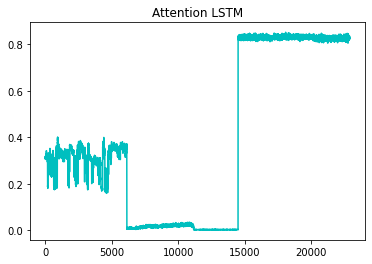

In [ ]:
# attn_preds.plot()
plt.plot(range(len(attn_preds)), attn_preds, color='c', );
plt.title("Attention LSTM")

# Attention LSTM + Kalman Filter

In [ ]:
#############################################
#       Attention LSTM + Kalman Filter      #
#############################################
# move all the training and prediction to GPU
gpus = tf.config.list_logical_devices('GPU')
# for reproducibility
seed = 42
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    print("Performing Attention + LSTM + Kalman Filtering ....")
    dataset = DataSet(fp="pred.csv")
    x_train,x_test, y_train, y_test = dataset.perfom_splits()
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    x_train = np.reshape(x_train, (len(x_train), time_steps, 1))  
    x_test = np.reshape(x_test, (len(x_test), time_steps, 1))

    model_attention_2 = create_LSTM_with_attention(hidden_units=hidden_units, dense_units=1, 
                                  input_shape=(time_steps,1), activation='tanh')

    # Train the model
    model_attention_2.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=2)
    # Evalute model
    train_mse_attn = model_attention_2.evaluate(x_train, y_train)
    test_mse_attn = model_attention_2.evaluate(x_test, y_test)
    # Predict the model
    attnKf_preds = model_attention_2.predict(dataset.X)

# Print error
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)
print("End of Attention LSTM Filtering")
print("End of Attneion+LSTM+KF")

Performing Attention + LSTM + Kalman Filtering ....
Epoch 1/10
20621/20621 - 69s - loss: 0.0021 - 69s/epoch - 3ms/step
Epoch 2/10
20621/20621 - 65s - loss: 2.2704e-04 - 65s/epoch - 3ms/step
Epoch 3/10
20621/20621 - 66s - loss: 1.8358e-04 - 66s/epoch - 3ms/step
Epoch 4/10
20621/20621 - 65s - loss: 1.5288e-04 - 65s/epoch - 3ms/step
Epoch 5/10
20621/20621 - 65s - loss: 1.3248e-04 - 65s/epoch - 3ms/step
Epoch 6/10
20621/20621 - 65s - loss: 1.2202e-04 - 65s/epoch - 3ms/step
Epoch 7/10
20621/20621 - 65s - loss: 1.1619e-04 - 65s/epoch - 3ms/step
Epoch 8/10
20621/20621 - 65s - loss: 1.1237e-04 - 65s/epoch - 3ms/step
Epoch 9/10
20621/20621 - 65s - loss: 1.0899e-04 - 65s/epoch - 3ms/step
Epoch 10/10
20621/20621 - 65s - loss: 1.0628e-04 - 65s/epoch - 3ms/step
717/717 [==============================] - 3s 3ms/step
Train set MSE with attention =  9.664325625635684e-05
Test set MSE with attention =  0.0003400403948035091
End of Attention LSTM Filtering
End of Attneion+LSTM+KF



# Results Table

|Model | MSE|
|:-:|:-:|
|Kalman| 0.005214702099193888
|LSTM | 0.009704818949103355
|LSTM + Kalman|0.0027847469318658113
|LSTM + Attention|0.00012966430222149938
|LSTM + Attention + Kalman| 7.888898835517466e-05




# Plotting Results

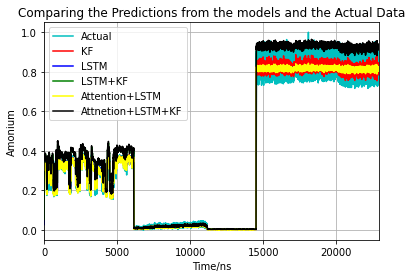

In [ ]:

# # Compare the MSE Losses
# plot_loss(mse_kf, mse_lstm)

# Compare the Predictions
plot_predictions(kf_preds, lstm_preds, lstmkf_preds, attn_preds, attnKf_preds,data)

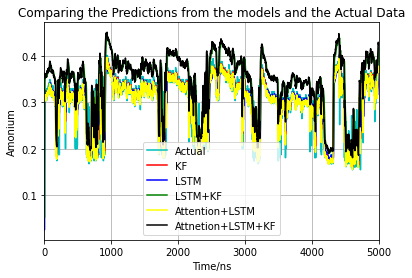

In [ ]:
def plot_predictions(preds1, preds2, preds3, preds4, preds5,  data):
    time = range(len(data))
    plt.figure()
    plt.plot(time, data, color='c', label='Actual')
    # plt.plot(time, preds1, color='r', label='KF')
    # plt.plot(time, preds2, color='b', label='LSTM')
    # plt.plot(time, preds3, color='g', label='LSTM+KF')
    # plt.plot(range(len(preds4)), preds4, color='yellow', label='Attention+LSTM')
    plt.plot(range(len(preds5)), preds5, color='black', label='Attnetion+LSTM+KF')
    plt.title("Comparing the Predictions from the models and the Actual Data")
    plt.xlim(0, len(data))
    plt.xlabel("Time/ns")
    plt.ylabel("Amonium")
    plt.legend()
    plt.grid()
    return plt.show()

# Compare the Predictions
plot_predictions(kf_preds[:5000], lstm_preds[:5000], lstmkf_preds[:5000], attn_preds[:5000], attnKf_preds[:5000],data[:5000])

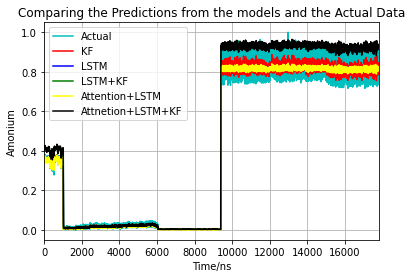

In [ ]:
plot_predictions(kf_preds[5120:len(data)], lstm_preds[5120:len(data)], lstmkf_preds[5120:len(data)], attn_preds[5120:len(data)], attnKf_preds[5120:len(data)],data[5120:len(data)])